#import

In [22]:
import os
import re
import cv2
import glob
import keras
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf
from scipy import signal
from matplotlib.pyplot import *
from skimage import color
from skimage.io import imread
from keras import backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from skimage.transform import resize
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.models import Sequential,Input,Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D


%matplotlib inline
tf.__version__

'2.8.0'

##Entrenamiento del modelo

Se conecta con google drive para cargar y guardar los nuevos modelos obtenidos del entrenamiento

**Se debe aceptar el permiso que se muestra a continuación para guardar los modelos creados**

Si no se acepta el permiso para para ver, editar, crear y eliminar archivos en su google drive entonces no se guardaran los nuevos modelos ni podrá cargar otros modelos

Se debe crear un acceso directo de la carpeta llamada models en "Mi unidad" de drive, de está forma se pueden usar los modelos de esa carpeta.

In [23]:
#@title permisos para google drive { display-mode: "form" }

from google.colab import drive
import os
saveModel = False
try:
  drive.mount('/content/drive')
except:
  print("Si quiere guardar los modelos creados debe aceptar el permiso para para ver, editar, crear y eliminar archivos en su google drive")
try:
  if os.path.isdir('./drive/MyDrive/models'):
    print("\nLos modelos se guardarán en su directorio models")
    saveModel = True
  else:
    os.mkdir('./drive/MyDrive/models')
    print("\nLos modelos se guardarán en un directorio llamado models en su unidad de drive")
    saveModel = True
except:
    saveModel = False
    print("\nNo se tiene permiso para acceder a drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Los modelos se guardarán en su directorio models


In [24]:
#@title Se cargan los modelos y las imagenes para probarlo { display-mode: "form" }
#Los modelos a usar deben estar en la carpeta llamada models en drive
#Esto también funciona si se crea un acceso directo de la carpeta llamada models 
#que se encuentra en la entrega
!git clone https://github.com/Kadyha/Brain_Tumor_Detection_MRI.git

noTumorImages = [cv2.imread(file).mean(axis=2) for file in glob.glob("Brain_Tumor_Detection_MRI/data/no/*.jpg")]
yesTumorImages = [cv2.imread(file).mean(axis=2) for file in glob.glob("Brain_Tumor_Detection_MRI/data/yes/*.jpg")]

def get_img(images):
  for i in range(len(images)):
    images[i] = resize(images[i], output_shape=(224,224,3))
    images[i] = ((images[i]-np.min(images[i]))/(np.max(images[i])-np.min(images[i]))*255).astype(int)
  return images

noTumorImages = get_img(noTumorImages)
yesTumorImages = get_img(yesTumorImages)

X = np.array(noTumorImages + yesTumorImages, dtype=np.uint8)
y = np.concatenate((np.zeros(len(noTumorImages)), np.ones(len(yesTumorImages))), axis=None)

XTrainTest, XVal, yTrainTest, yVal = train_test_split(X,y,test_size=0.1)
XTrain, XTest, yTrain, yTest = train_test_split(XTrainTest,yTrainTest,test_size=0.2)


fatal: destination path 'Brain_Tumor_Detection_MRI' already exists and is not an empty directory.


In [25]:
#@title elija el número de modelo que desea cargar { display-mode: "form" }

#Número del modelo que será cargado, Si ese modelo no existe se buscará uno anterior en la misma ubicación
numModel =  "BestModel" #@param ["BestModel",1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
numModel =  11 if numModel == "BestModel" else int(numModel)

RES_DIR = './drive/MyDrive/models/'
FILE_P = '%sBrain_tumor_detector%d'
FILE_PATH = ''+ FILE_P + '.h5'
if saveModel == False:
  print('\nNo se cargarán modelos ya que no se acepto el permiso para para ver, editar, crear y eliminar archivos en su google drive')
else:
  for i in range(numModel):
    if os.path.isfile(FILE_PATH % (RES_DIR, numModel-i)) and saveModel:
      model = keras.models.load_model(FILE_PATH % (RES_DIR, numModel-i))
      print('\nSe cargó el modelo número ', numModel-i)
      numModel = numModel-i
      break  


Se cargó el modelo número  11


##Evaluación del modelo

####Perdida y exactitud

In [ ]:
test_loss, test_acc = model.evaluate(XTest, yTest)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

17/17 [==============================] - 166s 10s/step - loss: 0.5523 - accuracy: 0.8407
Test loss: 0.5523318648338318
Test accuracy: 0.8407407402992249


In [ ]:
val_loss, val_acc = model.evaluate(XVal, yVal)
print('Val loss:', val_loss)
print('Val accuracy:', val_acc)

10/10 [==============================] - 92s 9s/step - loss: 0.5999 - accuracy: 0.8833
Val loss: 0.5998829007148743
Val accuracy: 0.8833333253860474


####Predicciones

In [26]:
predictions = model.predict(XVal)

Predicción de un grupo de imágenes

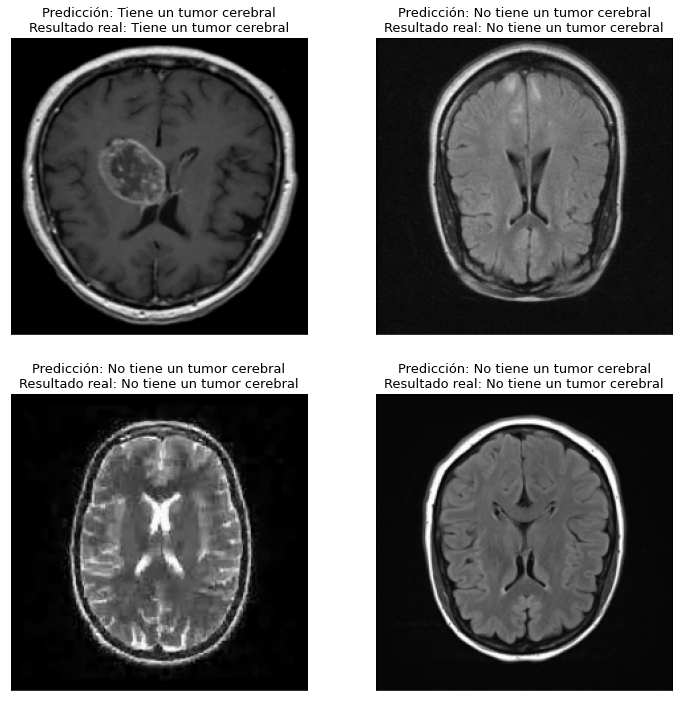

In [27]:
rows = 2  #Número de imágenes en las filas
columns = 2  #Número de imágenes en las columnas
fig = plt.figure(figsize=(12, 12))
for i in range(1, columns*rows +1):
  nimg = np.random.randint(len(XVal)) # Número de la imagen que se desea predecir
  if np.argmax(predictions[nimg]) == 0:
    title = "Predicción: No tiene un tumor cerebral"
  else:
    title = "Predicción: Tiene un tumor cerebral"
  if yVal[nimg] == 0:
    subtitle = "Resultado real: No tiene un tumor cerebral"
  else:
    subtitle = "Resultado real: Tiene un tumor cerebral"
  text = (title+"\n"+subtitle)
  fig.add_subplot(rows, columns, i)
  plt.xticks([]), plt.yticks([])
  plt.title(text,fontsize= 13)
  plt.imshow(XVal[nimg], cmap=plt.cm.Greys_r)
plt.show()

Predicción individual

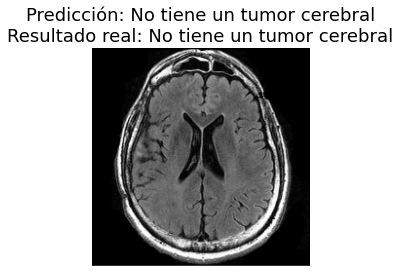

In [ ]:
nimg = np.random.randint(len(XVal)) # Número de la imagen que se desea predecir
#nimg = input()
if np.argmax(predictions[nimg]) == 0:
  title = "Predicción: No tiene un tumor cerebral"
else:
  title = "Predicción: Tiene un tumor cerebral"
if yVal[nimg] == 0:
  subtitle = "Resultado real: No tiene un tumor cerebral"
else:
  subtitle = "Resultado real: Tiene un tumor cerebral"
text = (title+"\n"+subtitle)
plt.xticks([]), plt.yticks([])
plt.title(text,fontsize= 18)
plt.imshow(XVal[nimg], cmap=plt.cm.Greys_r)

Matriz de confusión

[[157   3]
 [108  32]]


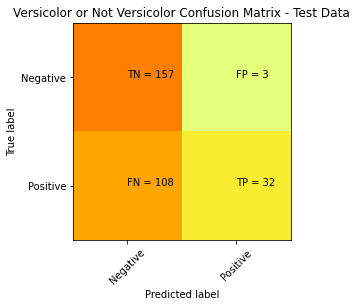

In [ ]:
yPred = []
for i in predictions:
  yPred = yPred + [np.argmax(i)]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yVal, yPred)
print(cm)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()